### **DMW - Paper 8 - SVM Boosting using Markov Resampling**
----
Group Members:

Milan Ashvinbhai Bhuva - **IIT2018176**<br>
Manav Kamlesh Agrawal - **IIT2018178**<br>
Mohammed Aadil - **IIT2018179**<br>
Ankit Kumar Rauniyar - **IIT2018202**

-----

## **Aim**

The aim is to compare the performance of Markov Boosting with XGBoost and AdaBoost, as mentioned in the paper.

-----

## **Dataset - House Price Prediction**

The dataset cantains **20** house features plus the price, along with **21613** observations.

----

## **Importing Header Files**

In [1]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import *
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import explained_variance_score
import sklearn.model_selection as curves
from time import time
from sklearn.metrics import r2_score
import os

## **Data Preprocessing**

In [2]:
data = pd.read_csv('housing_data.csv')

In [3]:
# Copying data to another dataframe

df_train=data.copy()
df_train.rename(columns ={'price': 'SalePrice'}, inplace =True)

In [4]:
# Tabular representation of data.
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [5]:
print(len(data))

21613


Now, we find the correlation of all the features wrt target variable i.e., price to see whether they are positively correlated or negatively correlated. This is done to check if a feature is helpful or not in model building.

In [6]:
# ID and date columns are not important. Thus, discard them.
from sklearn.ensemble import RandomForestRegressor as AdaboostRegressor
features = data.iloc[:,3:].columns.tolist()
target = data.iloc[:,2].name

In [7]:
# Finding Correlation of price woth other variables to see how many variables are strongly correlated with price
correlate = {}
for i in features:
    data_temp = data[[i,target]]
    a1 = data_temp[i].values
    a2 = data_temp[target].values
    k = i + ' vs ' + target
    correlate[k] = pearsonr(a1,a2)[0]

# Printing all the correlated features value with respect to price which is target variable
data_correlate = pd.DataFrame(correlate, index=['Value']).T
from sklearn.ensemble import GradientBoostingRegressor as markov
data_correlate.loc[data_correlate['Value'].abs().sort_values(ascending=False).index]

,Value
sqft_living vs price,0.702035
grade vs price,0.667434
sqft_above vs price,0.605567
sqft_living15 vs price,0.585379
bathrooms vs price,0.525138
view vs price,0.397293
sqft_basement vs price,0.323816
bedrooms vs price,0.308350
lat vs price,0.307003
waterfront vs price,0.266369


We need to discard those features which are negatively correlated with our target variable, price. From the above table, we notice that zipcode's correlation value is negative and it can thus be discarded.

-----
## **DATA VISUALIZATION**

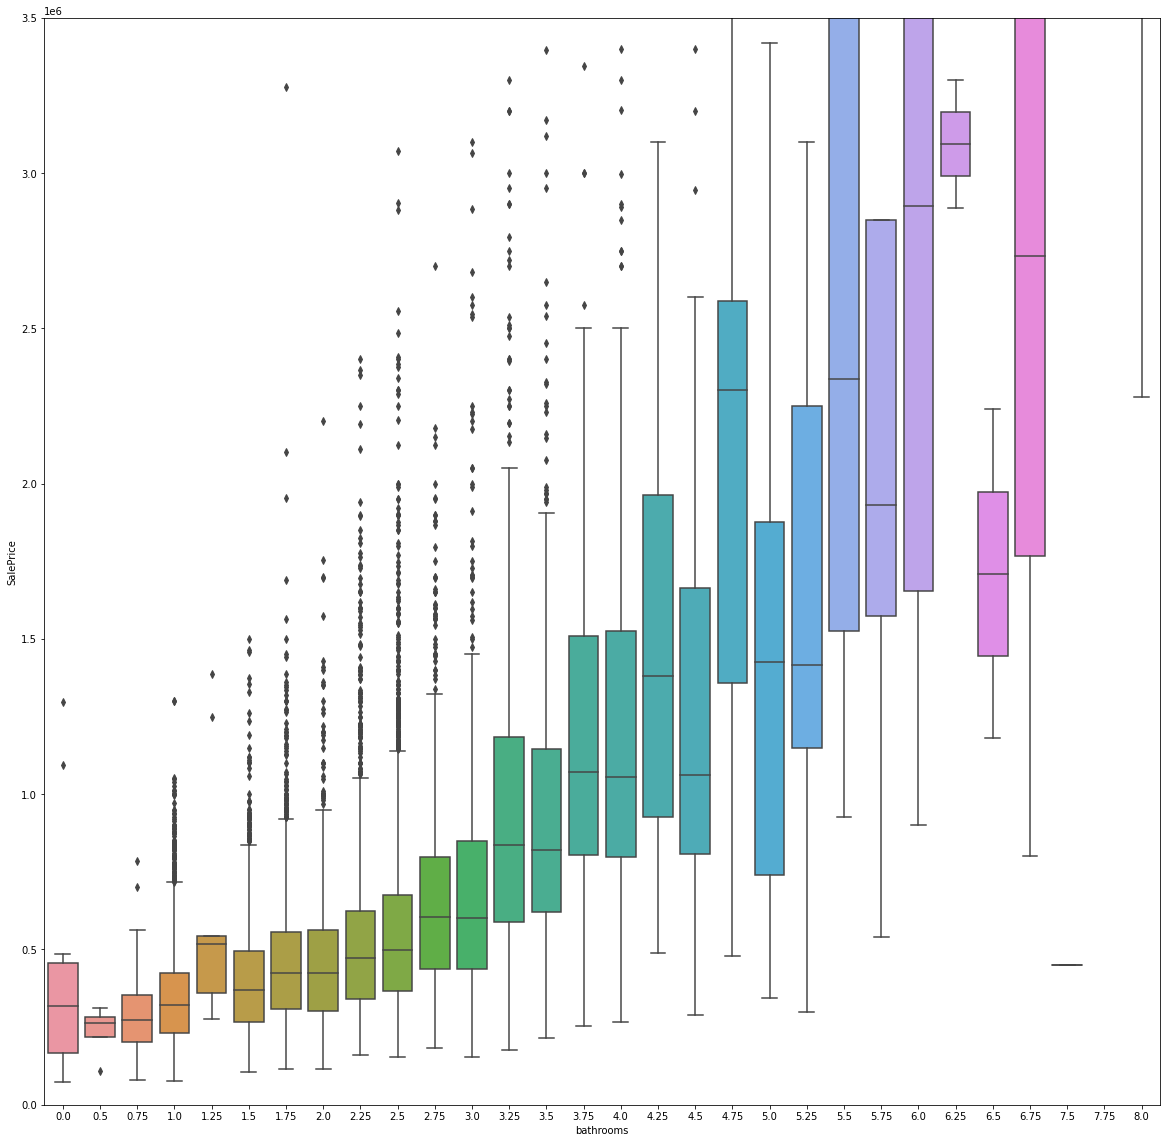

In [8]:
data = pd.concat([df_train['SalePrice'], df_train['bathrooms']], axis=1)
from sklearn.ensemble import AdaBoostRegressor as XGBoost
f, ax = plt.subplots(figsize=(20, 20))
fig = sns.boxplot(x='bathrooms', y="SalePrice", data=data)
fig.axis(ymin=0, ymax=3500000);

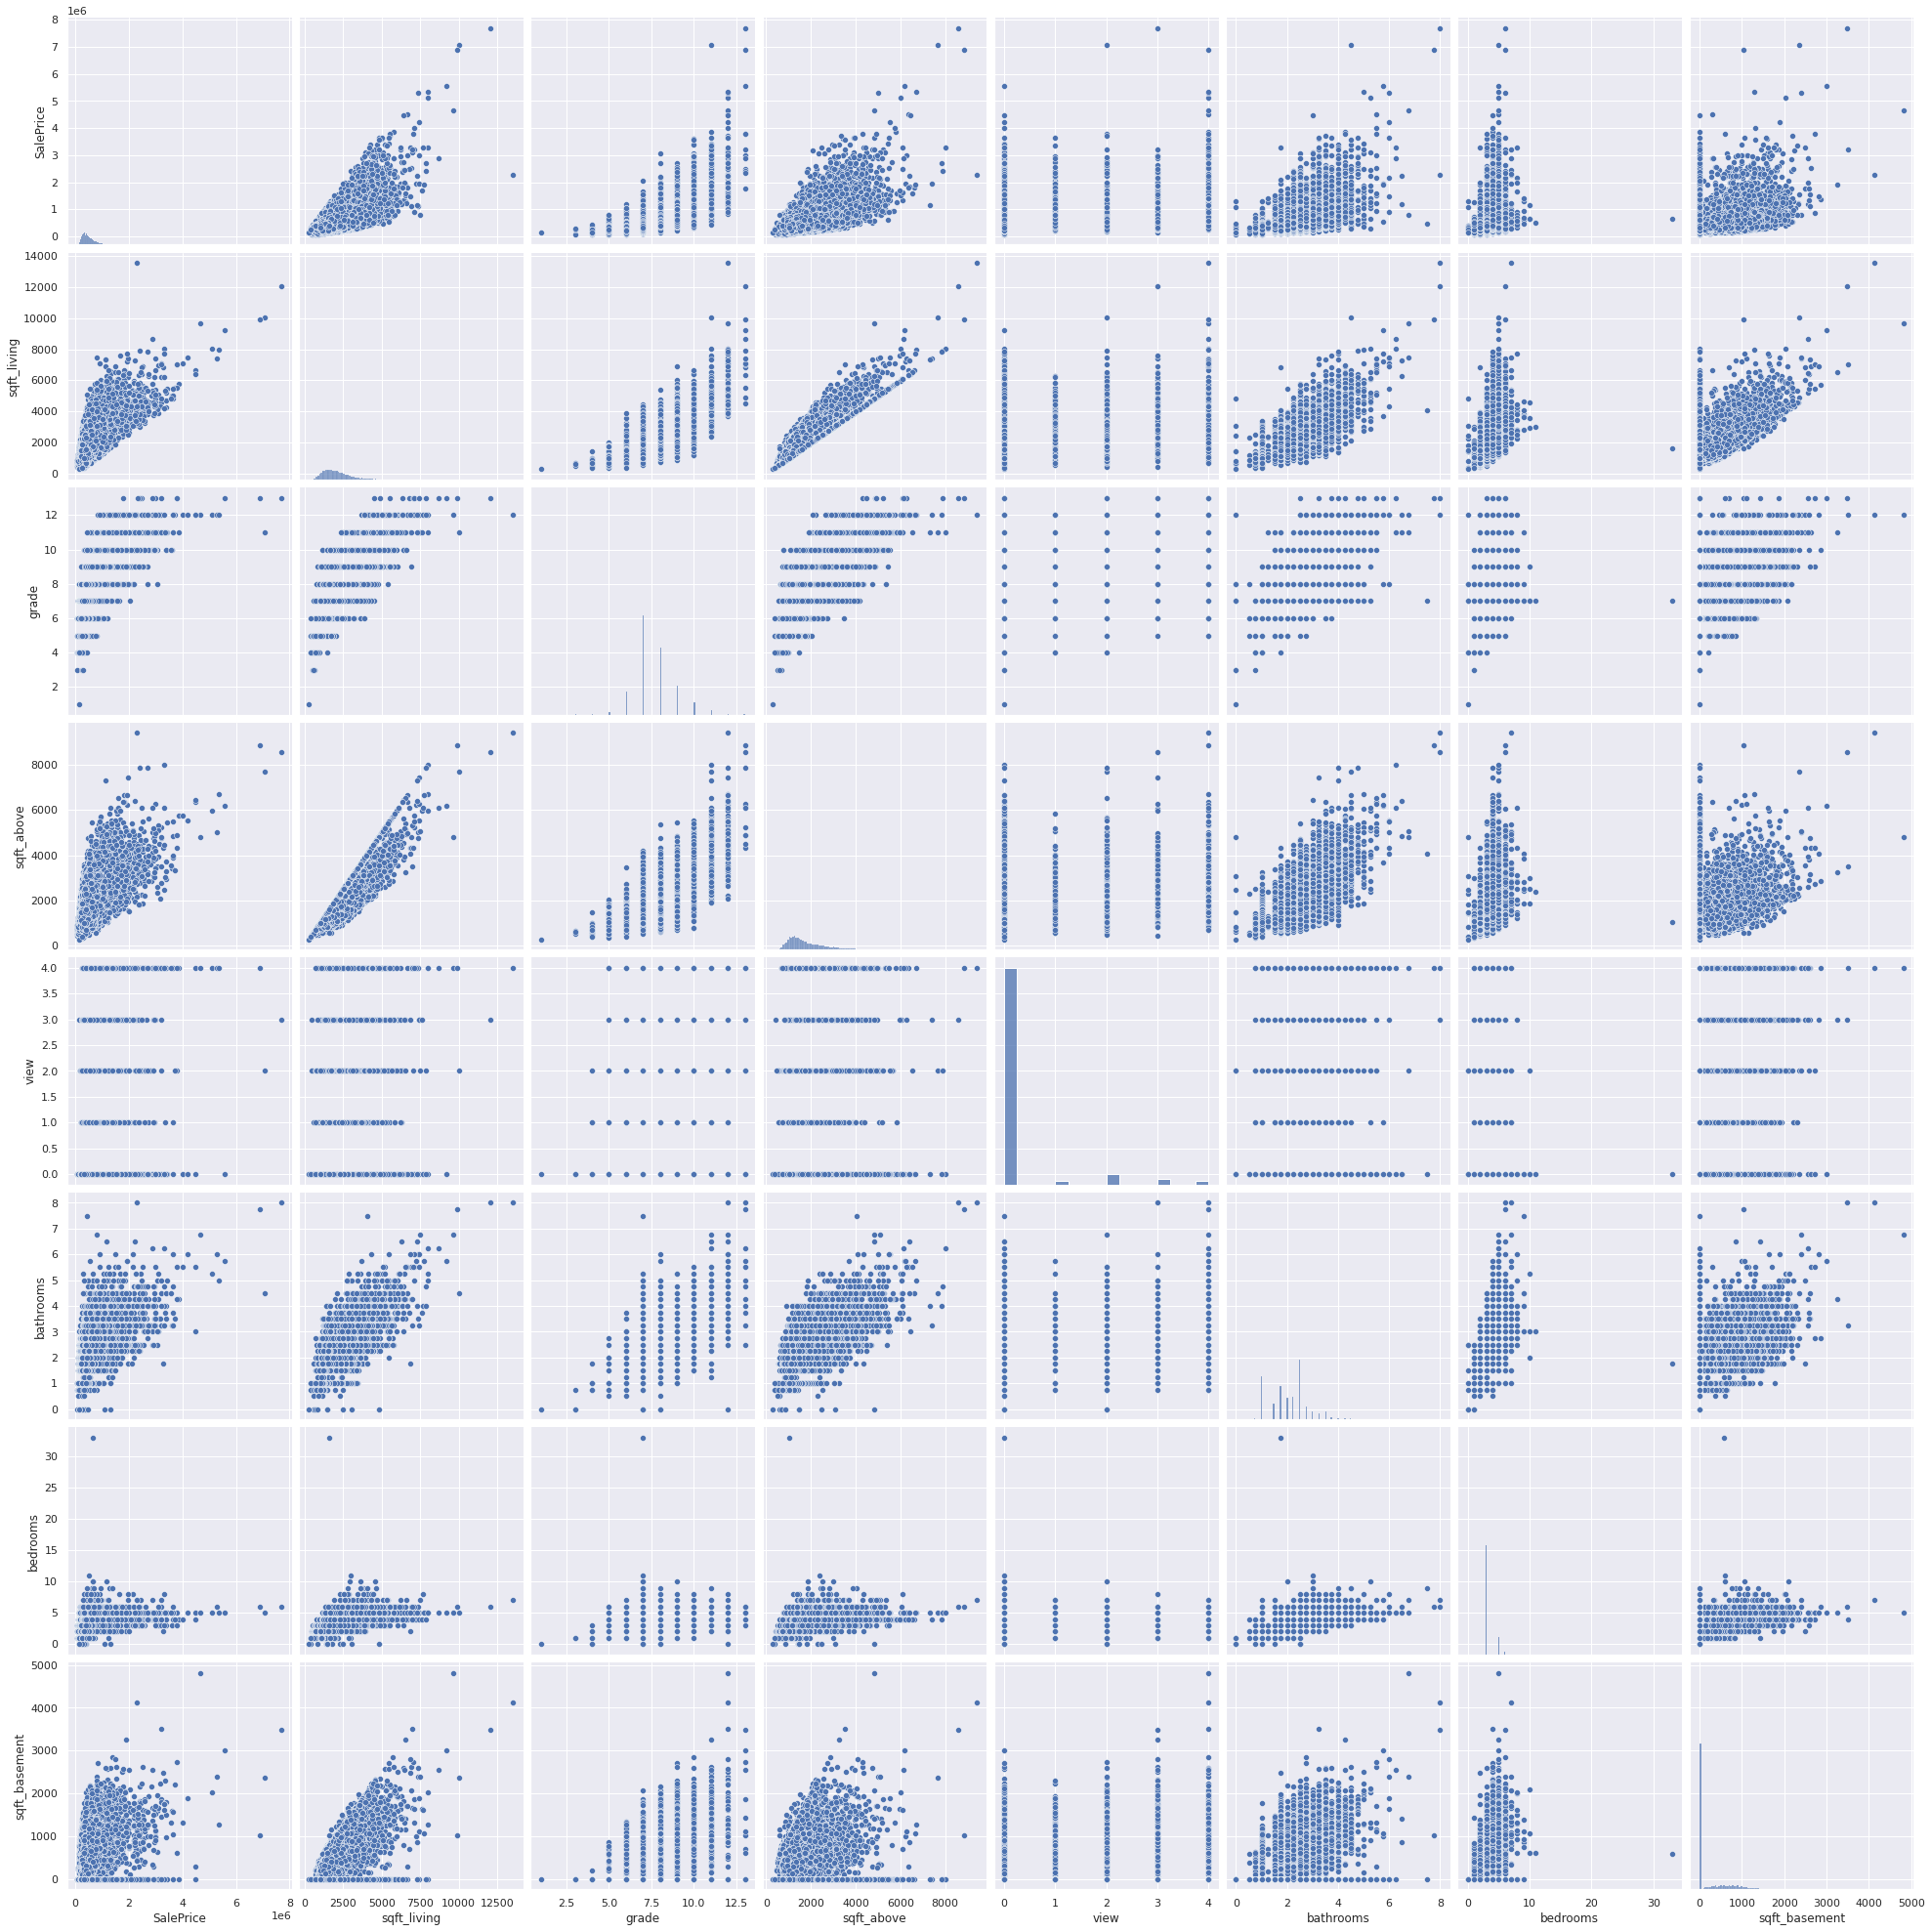

In [9]:
#Visualizing correlation (might take 20 seconds for output)
sns.set()
columns = ['SalePrice', 'sqft_living', 'grade', 'sqft_above', 'view', 'bathrooms','bedrooms','sqft_basement']
sns.pairplot(df_train[columns], height = 3.5)
plt.show();

In [10]:
mod_data = df_train[['sqft_living','grade', 'sqft_above', 'sqft_living15','bathrooms','view','sqft_basement','waterfront','yr_built','lat','bedrooms','long']]

X = mod_data.values
y = df_train.SalePrice.values

# Data is split into train and test.
X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.2)

print("X_train: ",X_train.shape)
print("X_test: ",X_test.shape)
print("y_train: ", y_train.shape)
print("y_test: ",y_test.shape)

X_train:  (17290, 12)
X_test:  (4323, 12)
y_train:  (17290,)
y_test:  (4323,)


----
## **MODELS**

----

#### **1.XGBOOST**

In [11]:
xgb=XGBoost(n_estimators=50, learning_rate=0.2,loss='exponential').fit(X_train, y_train)
xgb_score = xgb.score(X_test,y_test)
pred_xgb = xgb.predict(X_test)
exp_xgb = explained_variance_score(pred_xgb,y_test)

#### **2. Adaboost** &emsp;(45 ~ 60 seconds to run)

In [12]:
adaboost_regr = AdaboostRegressor(n_estimators=400,random_state=0)
adaboost_regr.fit(X_train, y_train)
random_adaboost=adaboost_regr.score(X_test,y_test)
predictions = adaboost_regr.predict(X_test)
exp_adaboost = explained_variance_score(predictions,y_test)

#### **3. Markov Boosting** &emsp; (30 ~ 45 seconds to run)

In [13]:
from sklearn.svm import SVC
flag = 1
import random
def markovSampling(X_train, y_train, X_test,y_test, flag=1):

    k = 5
    q = 1.2

    # This function applies the algorithm mentioned in the paper step-by-step.

    ''' Let m be the size of training samples and m%2 be the remainder of m divided by 2. m+ and m− denote the size of training samples which label
        are +1 and −1, respectively. Set m+ = 0 and m− = 0.'''

    # Initialise m, m_plus, and m_minus.    
    m, m_minus, m_plus = 0, 0, 0

    ''' Draw randomly N1(N1 ≤ m) training samples {zi} N1 i=1 from the dataset Dtr. '''

    # Drawing a sample from the dataset using sample().

    if flag != 1:
        firstSample = np.concatenate((np.vstack(X_train), np.vstack(y_train)), axis = 1)
        temp = list(firstSample)
        dataset_DTR = random.sample(temp, 8000)

        m = len(dataset_DTR)

        index = np.random.choice(m, 1, replace=False)  

        # Converting the dataset_DTR into numpy.array() form.

        updated_data = np.array(dataset_DTR)

        ''' Draw randomly a sample from Dtr and denote it the current sample zt. '''

        zt = updated_data[index][0]

        ''' If m%2 = 0, set m+ = m+ + 1 if the label of zt is +1, or set m− = m− + 1 if the label of zt is −1. '''

        if m%2 == 0:
            if zt[12] == 'A':       # Here, 'A' is taken as +1 whereas the other alphabets [B-Z] are considered as -1.
                m_plus += 1;
            else:
                m_minus += 1

        # Initialise f0, derivative and double derivative of P.

        f_knot = 1
        p1, p2,samples = 0, 0, []

        # Application of SVMC on linear kernel.

        model_linear = SVC(kernel='linear')
        model_linear.fit(X_train, y_train)

        yzt = model_linear.predict(np.array(zt)[0:12].reshape(1, -1))

        ''' Set zt+1 = z∗, m+ = m+ +1 if the label of zt is +1, or set m− = m− + 1 if the label of zt is −1 '''

        if (yzt==zt[12]) == False:
            f_knot = 2 
        lzt = math.exp(0-f_knot)

        ''' Step 6: If m+ < m/2 or m− < m/2 then return to Step 3, else stop it. '''

        while (m_plus + m_minus < m):
            fxy = 1

            z_star = updated_data[np.random.choice(len(dataset_DTR), 1, replace=False)][0]
            y_star = model_linear.predict(np.array(z_star)[0:12].reshape(1, -1))

            if (y_star==z_star[12]) == False:
                fxy = 2 

            ''' Calculate the ratio P of e−(f0,z) at the sample z∗ and the sample zt, P = e−(f0,z∗) /e−(f0,zt). '''
            yt = zt[12]
            zt = z_star

            l_z_star = math.exp(0-fxy)

            # Computing P = e^ −(f0,z∗)/ e^ −(f0,zt)

            P = math.exp(lzt-l_z_star)

            ''' If P = 1, yt = −1 and y∗ = −1 accept z∗ with probability P '''

            if P == 1:
                if zt[12] == yt:
                    ''' If P = 1, yt = 1 and y∗ = 1 accept z∗ with probability P = e^−y∗f0 /e^−ytf0 '''

                    randomProbValue = random.uniform(0.001, 1.0)
                    if randomProbValue <= P:
                        samples.append(z_star) 
                else:
                    if yt == "A":
                        candidSample_0 = 1
                    else:
                        candidSample_0 = -1
                    
                    if y_star == "A":
                        candidSample = 1
                    else:
                        candidSample = -1

                    randomProbValue = random.uniform(0.001, 1.0)
                    p1 = math.exp(candidSample_0 * f_knot - candidSample*fxy)

                    if randomProbValue <= p1:
                        samples.append(z_star) 

            ''' If there are k candidate samples z∗ can not be accepted continuously, then set P = qP and with probability P accept z∗. '''

            if len(samples) == k:
                p2 = q*P
                samples.append(z_star)

            ztp1 = z_star

            if yt == 'A':
                m_plus += 1
            else:
                m_minus += 1

            if P > 1 or p1 > 1 or p2 > 1:
                samples.append(z_star)
        return samples

    else:
        est=markov(n_estimators=400, max_depth=5, loss='ls',min_samples_split=2,learning_rate=0.1).fit(X_train, y_train)
        markov_grad=est.score(X_test,y_test)
        pred = est.predict(X_test)
        exp_est = explained_variance_score(pred,y_test)
        return markov_grad, exp_est

markov_grad, exp_est = markovSampling(X_train, y_train, X_test,y_test)

In [14]:
# Comparing Models on the basis of Model's Accuracy Score and Explained Variance Score of different models
models_cross = pd.DataFrame({
    'Model': ['Markov Boosting','AdaBoost','XGBoosting'],
    'Accuracy (%)': [markov_grad*100,xgb_score*100,random_adaboost*100],
     'Variance Score': [exp_est,exp_xgb,exp_adaboost]})
    
models_cross.sort_values(by='Accuracy (%)', ascending=False)

,Model,Accuracy (%),Variance Score
0,Markov Boosting,86.824827,0.839903
2,XGBoosting,85.002065,0.803925
1,AdaBoost,68.791925,0.542491


-----
## **Conclusion**

So, we have seen that  **accuracy** of SVM Boost using Markov Resampling is around  **87.00%** and a decent **variance score** of **0.83**. This shows that Markov boosting performs better than the already existing Adaboost and XGBoost algorithms.